# Example 

Here we'll go into more detail on the Quick Start Example from
:doc:'getting_started'. In this example, we'll build a pipeline that
uses a Savitzky-Golay filter to compute the first derivative of the
measurement, then computes the similarity between the derivative and
itself, then clusters the data using spectral clustering, and finally
fits a Gaussian Process classifier to the data.

## Input Data

First let's define the input data for the pipeline. These data will be randomly generated for the purposees of this example but, for real applications, these data would come from your instrument or measurement device.

This codebase uses :py:class:`xarray.Dataset` to store all input, intermediate, and output data. This is a powerful and flexible data structure for working with multi-dimensional data.


To begin, let's make an empty :py:class:`xarray.Dataset`

In [1]:
import numpy as np
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.Dataset()
ds

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

### Compositions

Next, we generate random 'compositions' that we'll do simulated/virtual measurements at. We'll generate the compositions for a 2-dimensional space with components "A" and "B" as placeholders. You could imagine that A and B are the concentrations of two different preservatives in a liquid mixtures. 

In [2]:

num_measurements = 100
A = np.random.uniform(0,10,size=num_measurements)
B = np.random.uniform(0,25,size=num_measurements)
compositions = np.array([A,B]).T
compositions

array([[ 4.16447342, 22.6550266 ],
       [ 2.60520523, 10.31829741],
       [ 1.6086785 ,  4.3848982 ],
       [ 2.85179736, 13.34761388],
       [ 1.30646617,  1.89875341],
       [ 2.10821603,  9.00173463],
       [ 9.33197423, 11.20179991],
       [ 0.07221554, 22.40296008],
       [ 1.22129229,  6.65805789],
       [ 6.28987831,  8.52706328],
       [ 1.6605554 ,  2.4250757 ],
       [ 3.10873937, 15.70104302],
       [ 5.11938933,  7.62240709],
       [ 5.49126138, 15.82572878],
       [ 1.41125963, 18.75699147],
       [ 3.35159244, 16.57163449],
       [ 3.16951155, 21.11010924],
       [ 2.50907993, 15.13245804],
       [ 1.59827103, 19.74273542],
       [ 3.26190972, 20.79766727],
       [ 8.44764137,  7.02865451],
       [ 6.10685478,  9.43789648],
       [ 9.44506637, 11.92648908],
       [ 1.54335847,  7.69539584],
       [ 4.96383655, 20.73674567],
       [ 1.51033822, 12.76426113],
       [ 4.97530175, 24.32731447],
       [ 4.3400415 ,  7.89234481],
       [ 8.30910172,

Now let's add this information to the :py:class:`xarray.Dataset`. 

Note how, for the `composition` variable, we need to not only specify the name of the variable in the dataset but also the names of the dimensions of the data ('sample' and 'components').

In [3]:

ds['compositions'] = (['sample','components'],compositions)
ds['components'] = ('components',['A','B'])
ds


<xarray.Dataset> Size: 2kB
Dimensions:       (sample: 100, components: 2)
Coordinates:
  * components    (components) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    compositions  (sample, components) float64 2kB 4.164 22.66 ... 1.402 16.09

Okay, in order to simulate a 'phase boundary' we'll create labels for the data. We'll draw an arbitrary line through the composition space and label the data that is above and below that line. 

Let's generate this data and add it to the dataset

In [4]:
labels = (A>(0.25*B-1)).astype(int)
ds['ground_truth_labels'] = ('sample',labels)
ds

<xarray.Dataset> Size: 2kB
Dimensions:              (sample: 100, components: 2)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    compositions         (sample, components) float64 2kB 4.164 22.66 ... 16.09
    ground_truth_labels  (sample) int64 800B 0 1 1 1 1 1 1 0 ... 1 1 1 1 1 1 1 0

Now we can plot the data. We do this using xarray by first extracting the compositions data variable into a new standalone xarray.Dataset and then calling plot.scatter on it. 

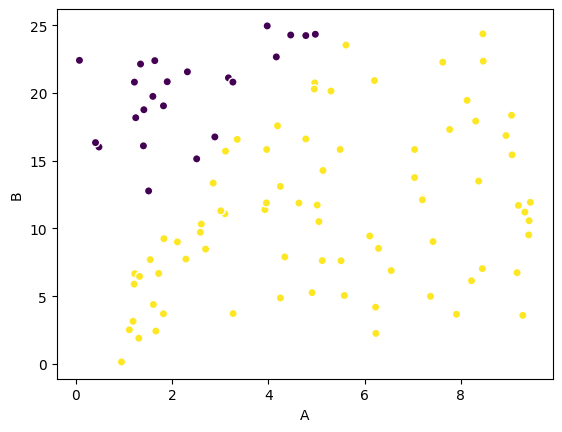

In [5]:
ds.compositions.to_dataset('components').plot.scatter(x='A',y='B',c=ds.ground_truth_labels)

### Simulated Measurement Data

Now let's generate the 'measurement' data. We'll generate one measurement for each composition generated above. We'll generate two kinds of data that depend on the data label:

1. A flat background signal with random Gaussian noise
2. A linear signal with a slope of -4 and random Gaussian noise


In [6]:

#domain of the measurements (e.g., for scattering this would be q, for
#spectroscopy this would be wavelength or wavenumber)
x = np.linspace(0,10,125)

measurements = []
for label in labels:
    if label==0:
        measurements.append(np.random.normal(0, 1.0, x.shape[0]))
    else:
        measurements.append(-4*x + np.random.normal(x, 1.0,x.shape[0]))


# Add the measurement data to the dataset
ds['measurement'] = (['sample','x'],measurements)
ds['x'] = ('x',x)
ds


<xarray.Dataset> Size: 103kB
Dimensions:              (sample: 100, components: 2, x: 125)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.0 0.08065 0.1613 ... 9.839 9.919 10.0
Dimensions without coordinates: sample
Data variables:
    compositions         (sample, components) float64 2kB 4.164 22.66 ... 16.09
    ground_truth_labels  (sample) int64 800B 0 1 1 1 1 1 1 0 ... 1 1 1 1 1 1 1 0
    measurement          (sample, x) float64 100kB 0.02466 0.07648 ... 0.9893

Now let's plot the two groups of data

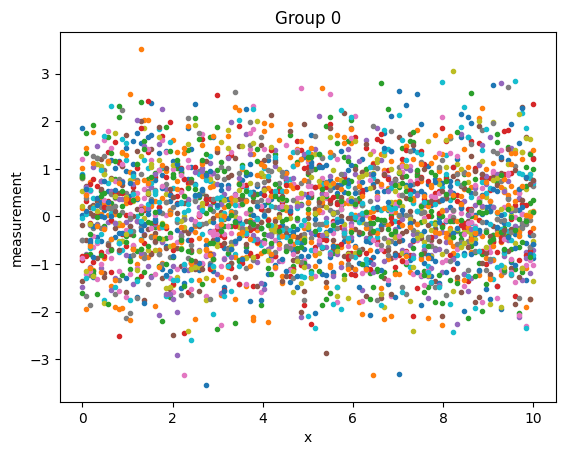

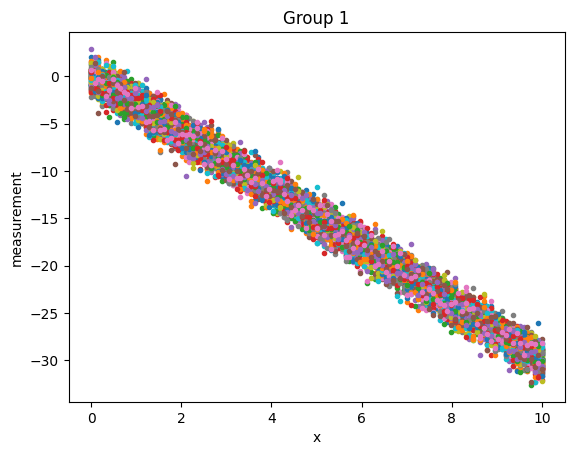

In [13]:
for label, sub_ds in ds.groupby('ground_truth_labels'):
    plt.figure()
    sub_ds.measurement.plot.line(x='x',marker='.',ls='None',add_legend=False)
    plt.title(f'Group {label}')

plt.show()


### Composition Grid

Okay, the final piece of data that you need to start is the composition grid. This grid defines the space that the agent will evaluate when choosing the next composition

In [22]:

num_grid_points = 50
A_grid = np.linspace(0,10,num_grid_points)
B_grid = np.linspace(0,25,num_grid_points)
composition_grid = np.meshgrid(A_grid,B_grid)
composition_grid = np.array([composition_grid[0].ravel(),composition_grid[1].ravel()]).T

ds['composition_grid'] = (['grid','components'],composition_grid)
ds

<xarray.Dataset> Size: 143kB
Dimensions:              (sample: 100, components: 2, x: 125, grid: 2500)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.0 0.08065 0.1613 ... 9.839 9.919 10.0
Dimensions without coordinates: sample, grid
Data variables:
    compositions         (sample, components) float64 2kB 4.164 22.66 ... 16.09
    ground_truth_labels  (sample) int64 800B 0 1 1 1 1 1 1 0 ... 1 1 1 1 1 1 1 0
    measurement          (sample, x) float64 100kB 0.02466 0.07648 ... 0.9893
    composition_grid     (grid, components) float64 40kB 0.0 0.0 ... 10.0 25.0

Let's inspect the grid in a plot

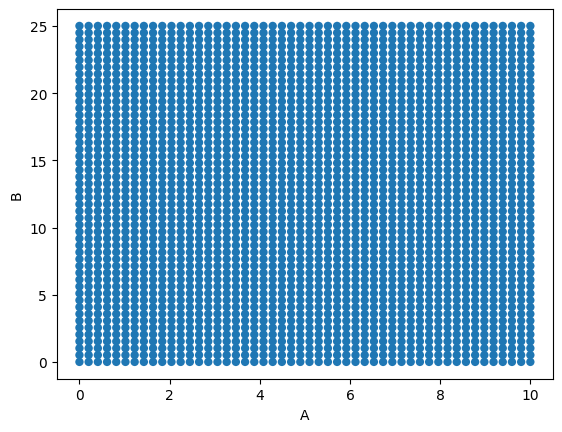

In [27]:
ds.composition_grid.to_dataset('components').plot.scatter(x='A',y='B',edgecolor='None')

## Pipeline Step 1: Savitsky-Golay Filter


Now that we have the data in place, we'll instantiate a :py:class:`SavgolFilter` object using the a context manager (i.e., the 'with' construct shown below). Using this approach, each Pipeline operation that is defined in the context is automatically added to the ``my_first_pipeline`` variable.

In [28]:
from AFL.double_agent import *

with Pipeline() as my_first_pipeline:

       SavgolFilter(
           input_variable='measurement', 
           output_variable='derivative', 
           dim='x', 
           derivative=1
           )


Going over the keyword arguments one by one:

- The ``input_variable`` keyword argument specifies the name of the variable in the dataset that will be used as
  the input to the Savitzky-Golay filter.
- The ``output_variable`` keyword argument specifies the name of the new variable that will be added to the dataset.
- The ``dim`` keyword argument specifies the dimension along which the filter will be applied.
- The ``derivative`` keyword argument specifies the order of the derivative to be computed.

We can inspect the pipeline by printing the ``my_first_pipeline`` variable.

In [29]:
my_first_pipeline.print()

PipelineOp                               input_variable ---> output_variable
----------                               -----------------------------------
0  ) <SavgolFilter>                      measurement ---> derivative

Input Variables
---------------
0) measurement

Output Variables
----------------
0) derivative


Finally, we can run the pipeline on the dataset and plot the results.

In [ ]:
ds_output = my_first_pipeline.calculate(ds)
display(ds_output)

ds_output.measurement.isel(sample=0).plot()
ds_output.derivative.isel(sample=0).plot()


# Full Pipeline

In [ ]:
from AFL.double_agent import *

with Pipeline() as my_first_pipeline:

    SavgolFilter(
        input_variable='measurement', 
        output_variable='derivative', 
        dim='x', 
        derivative=1
        )

    Similarity(
        input_variable='derivative', 
        output_variable='similarity', 
        sample_dim='sample',
        params={'metric': 'cosine'}
        )

    SpectralClustering(
        input_variable='similarity',
        output_variable='labels',
        dim='sample',
        )

    GaussianProcessClassifier(
        feature_input_variable='composition',
        predictor_input_variable='labels',
        output_prefix='extrap',
        sample_dim='sample',
        grid_variable='composition_grid',
        grid_dim='grid',

    )

    MaxValueAF(
        input_variables=['extrap_variance'],
        output_variable='next_sample',
        grid_variable='composition_grid',
    )

my_first_pipeline

<Pipeline Pipeline N=5>